Importing the Dependencies

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Device Configuration

In [55]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device

device(type='mps')

Data Collection and Preprocessing

In [56]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
X = data.data
y =  data.target

In [57]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [59]:
df.shape

(569, 30)

In [60]:
df.isna().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [61]:
df.duplicated().sum()

np.int64(0)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(569, 30)
(455, 30)
(114, 30)


In [64]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

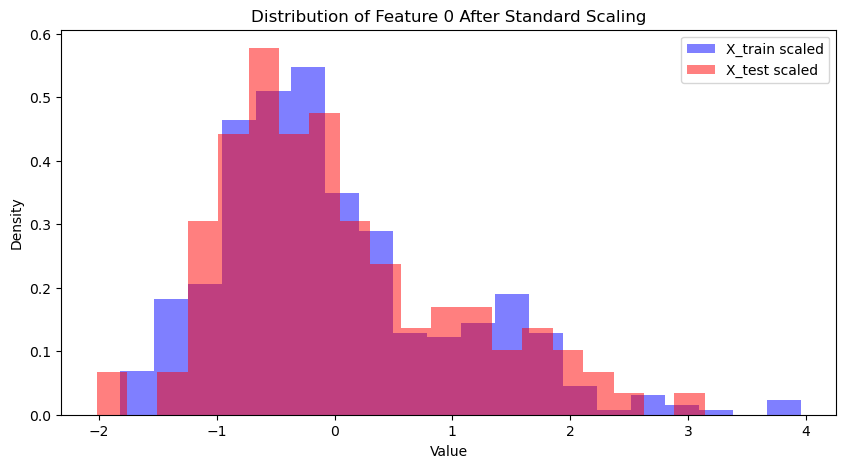

In [65]:
feature_idx = 0  

feature_train_scaled = X_train[:, feature_idx]
feature_test_scaled = X_test[:, feature_idx]

plt.figure(figsize=(10,5))
plt.hist(feature_train_scaled, bins=20, alpha=0.5, label='X_train scaled', color='blue', density=True)
plt.hist(feature_test_scaled, bins=20, alpha=0.5, label='X_test scaled', color='red', density=True)

plt.title(f"Distribution of Feature {feature_idx} After Standard Scaling")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [66]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

Neural Network Architecture

In [67]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out) 
        return out

Define Hyperparameters

In [68]:
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
lr = 0.001
epochs = 100

Create the Model

In [69]:
model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

Setting up Loss and the Optimizer

In [70]:
criterion = nn.BCELoss()
criterion

BCELoss()

In [71]:
optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

Writing the Loop

In [72]:
epoch_count, loss_values, test_loss_values, accuracy_values = [], [], [], []

for epoch in range(epochs):
    model.train()
    y_preds = model(X_train)
    loss = criterion(y_preds, y_train.view(-1,1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = criterion(test_preds, y_test.view(-1,1))
        
        predicted = y_preds.round()
        correct = (predicted == y_train.view(-1,1)).float().sum()
        acc = correct / y_train.size(0)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
        accuracy_values.append(acc.item())
        print(f"Epoch {epoch}: Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}, Accuracy={acc.item():.4f}")


Epoch 0: Loss=0.7409, Test Loss=0.7172, Accuracy=0.3560
Epoch 10: Loss=0.5776, Test Loss=0.5570, Accuracy=0.8769
Epoch 20: Loss=0.4570, Test Loss=0.4397, Accuracy=0.9253
Epoch 30: Loss=0.3642, Test Loss=0.3495, Accuracy=0.9363
Epoch 40: Loss=0.2933, Test Loss=0.2801, Accuracy=0.9495
Epoch 50: Loss=0.2405, Test Loss=0.2279, Accuracy=0.9582
Epoch 60: Loss=0.2017, Test Loss=0.1895, Accuracy=0.9604
Epoch 70: Loss=0.1731, Test Loss=0.1613, Accuracy=0.9670
Epoch 80: Loss=0.1517, Test Loss=0.1404, Accuracy=0.9736
Epoch 90: Loss=0.1353, Test Loss=0.1249, Accuracy=0.9758


Graphing Training and Testing Loss

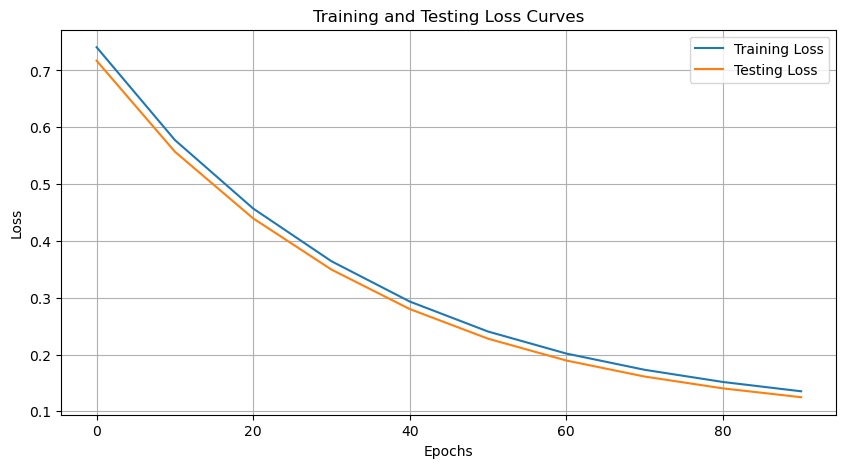

In [74]:
plt.figure(figsize=(10,5))

train_loss = np.array(loss_values)
test_loss = np.array(test_loss_values)

plt.plot(epoch_count, train_loss, label='Training Loss')
plt.plot(epoch_count, test_loss, label='Testing Loss')
plt.title('Training and Testing Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Graphing Accuracy

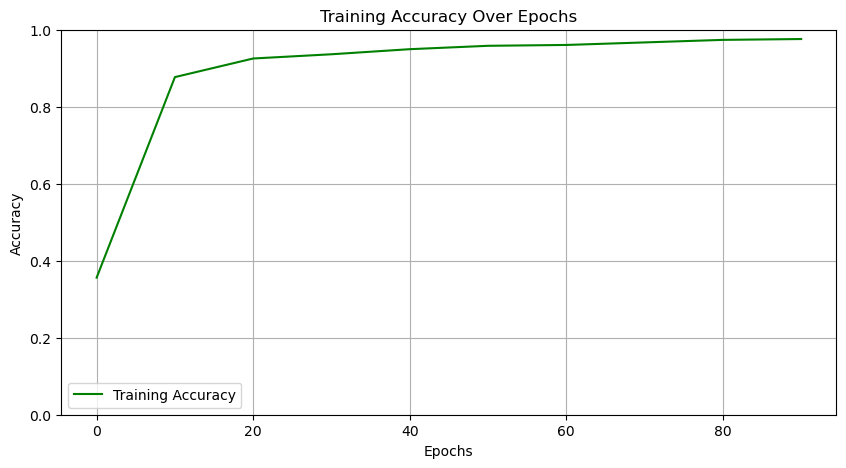

In [76]:
plt.figure(figsize=(10,5))

accuracy = np.array(accuracy_values)

plt.plot(epoch_count, accuracy, label='Training Accuracy', color='green')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()